GRID SIZE:  32
Data shape: (1000, 2)
Initialized with NEigs = 1000 (type: <class 'int'>)
entering try


/Users/seoli/Desktop/DIAMONDS/Tufts2024/lund/utils.py:59: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  eigvals, eigvecs = eigs(P, k = n_eigs)


sucessfully


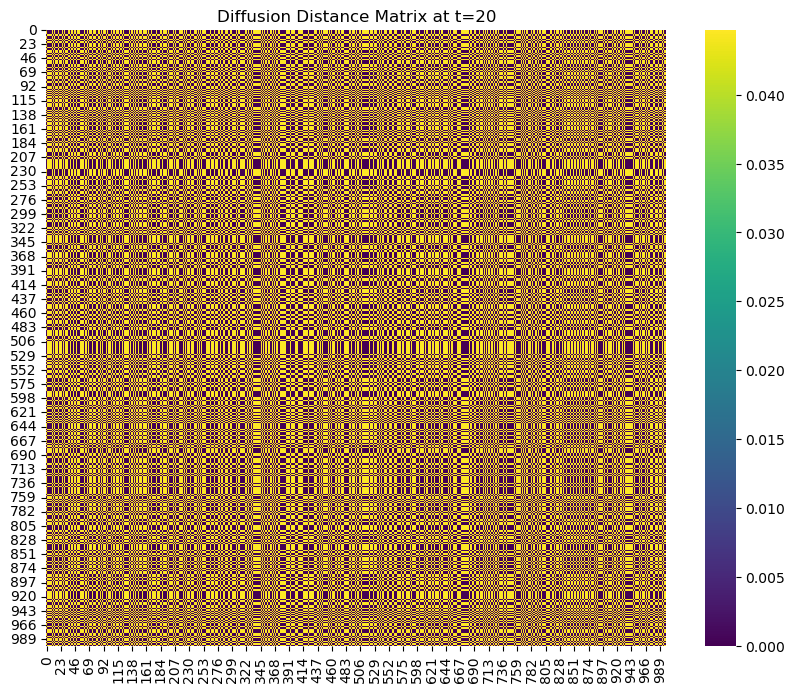

entered lund
Number of Eigenvalues: 1000
Number of Eigenvectors: (1000, 1000)
replicate error
m_sorting: [ 20 612 803 109 773 340 253  66 211  81 137 108  25 476 353  97 483 297
 868  35 176 758 562 990 752 932  40 974 802 161 477 304 350 709 661 818
  57 631 608 148 422 184 578 505  76 185 200 734 400 985 120 950 873 679
 270 774 855 224 693 403 666 470 678 727 959  50 271 164 225 165 954 524
 854 810 763 862 335 649 548 529 934 907 510 969  45 648 509 236 921 582
 102 473 569 413  18 955 265 300 637 168  91 610 706 906 613  27 118 345
 924 812 195 764 587 543 808 897 248 416 369 565 540 872 194 628 989 842
 641 767 689 895 951 968 301 307 541 970  67 382 170 500  53 592 131 655
 528 372 188 343 903 328 821 504 894 490 314  95 153 393 299 196 992 278
 210 285 589 284 881 209 146 129 333 205 594 179 656 611 614 896 145 771
 775 235 684 447 355 337 953 123 116 323 361 781 364 127 988 901  41 937
 466 863 563 293 804 420 217 516 204 430 532 254 388 760 409 573 272 536
 724 428 967 694 52

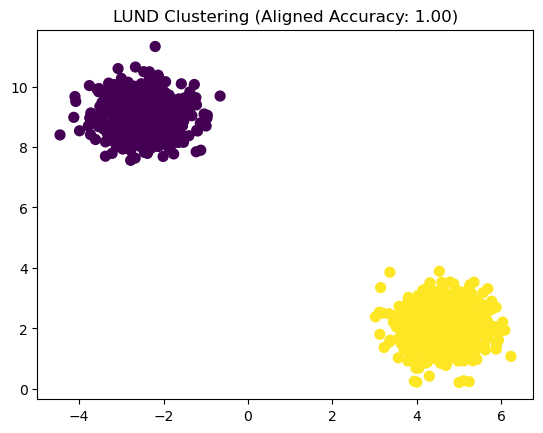

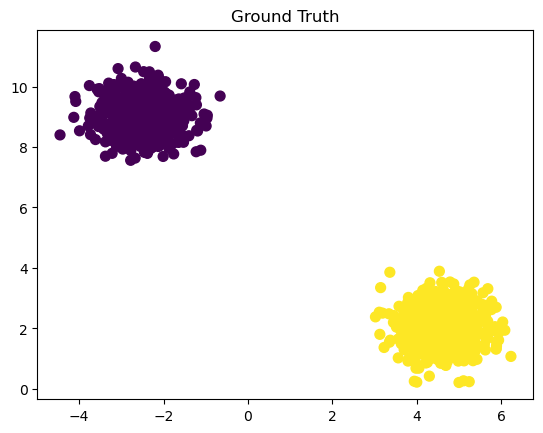

In [4]:
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
from sklearn.datasets import make_moons, make_blobs, make_classification
from sklearn.manifold import TSNE
from scipy.sparse.csgraph import laplacian
from scipy.spatial.distance import pdist, squareform
from lund.lund import LearningbyUnsupervisedNonlinearDiffusion
from lund.utils import GraphExtractor, diffusion_distance
from model.utils import loadHSI,calculate_aligned_accuracy
import matplotlib.pyplot as plt
import scipy.io


# data_path, gt_path, data_name, gt_name = '/Users/seoli/Desktop/DIAMONDS/Tufts2024/data/SalinasA_corrected.mat', '/Users/seoli/Desktop/DIAMONDS/Tufts2024/data/SalinasA_gt.mat', 'salinasA_corrected', 'salinasA_gt'


# X, M, N, D, HSI, GT, Y, n, K = loadHSI(data_path, gt_path, data_name, gt_name)
X, GT = make_blobs(n_samples=1000, centers=2, cluster_std=0.60, random_state=42)
scipy.io.savemat('data.mat', {'X': X, 'GT': GT})

grid_size = int(np.ceil(np.sqrt(X.shape[0])))
print("GRID SIZE: ", grid_size)

print("Data shape:", X.shape)

# GT = GT - 1
# HSI = X.reshape((M, N, D))
Hyperparameters = {
    'Sigma': 1.0,
    'DiffusionNN': 10,
    
}

kde = KernelDensity(bandwidth=1.0)
kde.fit(X)
log_density = kde.score_samples(X)
p = np.exp(log_density)

graph_extractor = GraphExtractor()
G = graph_extractor.extract_graph(X)

def check_orthogonality(eigvecs):
    n = eigvecs.shape[1]
    for i in range(n):
        for j in range(i+1, n):
            dot_product = np.dot(eigvecs[:, i], eigvecs[:, j])
            if not np.isclose(dot_product, 0):
                print(f"Eigenvectors {i} and {j} are not orthogonal: dot product = {dot_product}")
    print("Orthogonality check completed.")


t = 20
distances, embedding = diffusion_distance(G, 5)
distances, embedding = diffusion_distance(G, 20)
distances, embedding = diffusion_distance(G, 40)


def plot_diffusion_distance(timestep):
    distances, embedding = diffusion_distance(G, timestep)
    plt.figure(figsize=(10, 8))
    sns.heatmap(distances, cmap='viridis')
    plt.title(f'Diffusion Distance Matrix at t={t}')
    plt.show()
plot_diffusion_distance(5)
plot_diffusion_distance(20)
plot_diffusion_distance(40)

C, K, Dt = LearningbyUnsupervisedNonlinearDiffusion(X, t, G, p)


# print("Cluster labels:", C)
# print("GT",GT)
print("Number of clusters:", K)

accuracy = calculate_aligned_accuracy(GT, C)
print("Aligned Accuracy:", accuracy)

def plot_clusters(X, labels, title):
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
    plt.title(title)
    plt.show()
    
def plot_kde_density(X, title):
    # Create the KDE plot
    plt.figure(figsize=(10, 6))
    sns.kdeplot(x=X[:, 0], y=X[:, 1], cmap='viridis', fill=True, levels=20, thresh=0)
    plt.scatter(X[:, 0], X[:, 1], c='red', s=5, edgecolor='k')
    plt.title(title)
    plt.show()


plot_clusters(X, C, f"LUND Clustering (Aligned Accuracy: {accuracy:.2f})")
plot_clusters(X, GT, "Ground Truth")
# plot_kde_density(X, "KDE Density Estimation")

# kmeans = KMeans(n_clusters=2, random_state=42)
# kmeans_labels = kmeans.fit_predict(X)
# kmeans_accuracy = calculate_aligned_accuracy(GT, kmeans_labels)
# print("Aligned Accuracy (KMeans Clustering):", kmeans_accuracy)
# plot_clusters(X, kmeans_labels, f"KMeans Clustering (Aligned Accuracy: {kmeans_accuracy:.2f})")


